In [69]:
import IPython
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn
import numpy as np
import pandas as pd
import math
import torch

In [70]:
%matplotlib inline

In [71]:
# Zu Anschauungszwecken wollen wir im Beispiel-Notebook immer die gleichen Zufallsdaten generieren:
rand_seed = 42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

## Projektaufgaben
1. Wir haben uns hier als Beispiel eine lineare Funktion der Form $f: \mathbb{R} \rightarrow \mathbb{R}$ angeschaut, also ein Input-, ein Output-Wert und zwei Parameter. Bauen Sie ein eigenes Modul (wie oben Beispielhaft mit `MyLinear` geschehen), dass eine lineare Funktion mit $n$ Input-Parametern und $m$ Output-Werten nachbildet, also $f: \mathbb{R}^n \rightarrow \mathbb{R}^m$. Überlegen Sie sich wieviele Parameter eine solche Funktion braucht und wie man sie am besten darstellt.
2. Erzeugen Sie mehrdimensionale Beispieldaten, versehen Sie diese mit Rauschen und trainieren Sie Ihr Modul aus Aufgabe 1. darauf. Mehrdimensionale Funktionen lassen sich schwierig grafisch darstellen. Wie können Sie den Trainingsfortschritt verfolgen?

Bitte fassen Sie Ihre Lösungen in einem eigenen Jupyter-Notebook zusammen!

## Aufgabe 1

In [72]:
class MyLinear_mehrdim(torch.nn.Module):
    def __init__(self, n, m):
        super().__init__()
        self.matrix = torch.nn.Parameter(10*torch.rand((m, n), dtype=torch.float, requires_grad=True))  
        self.b = torch.nn.Parameter(10*torch.rand(m, dtype=torch.float, requires_grad=True))
        
    def forward(self, x):
        return x @ torch.transpose(self.matrix,0,1) + self.b


In [73]:
#Input- und Output-Parameter
n = 3
m = 2

In [74]:
my_linear = MyLinear_mehrdim(n,m) # z.B. n=3 m=2
list(my_linear.parameters())

[Parameter containing:
 tensor([[8.8227, 9.1500, 3.8286],
         [9.5931, 3.9045, 6.0090]], requires_grad=True),
 Parameter containing:
 tensor([2.5657, 7.9364], requires_grad=True)]

## Aufgabe 2

In [75]:
max_x = 50

mat = np.ones((m,n), dtype=float)
mat[0,0] = 0
b = np.array(np.random.randint(low=0, high=max_x, size=m), dtype=float)

def f(x):
    mat @ x + b

In [76]:
num_examples = 50

data = pd.DataFrame([[np.random.randint(low=0, high=max_x, size=n)] for x in range(num_examples)], columns=["x"]) # Python-Generator-Syntax

data["f(x)"] = [mat @ x + b for x in data["x"]]


In [77]:
data["f(x)+e"] = [y + np.random.randn(m)*2 for y in data["f(x)"]]
data.head()

x            f(x)                                    f(x)+e
0   [14, 42, 7]    [87.0, 91.0]    [84.16249908281719, 93.08498323467884]
1  [20, 38, 18]   [94.0, 104.0]    [95.80706498125168, 104.0380006621243]
2  [22, 10, 10]    [58.0, 70.0]    [56.93116709265299, 67.00989225837132]
3  [23, 35, 39]  [112.0, 125.0]  [110.42148334260416, 126.48742256754245]
4   [23, 2, 21]    [61.0, 74.0]   [60.575677156576745, 73.14626241192056]

In [78]:
x_1 = torch.tensor(data["x"], dtype=torch.float)
y_1 = torch.tensor(data["f(x)+e"], dtype=torch.float)

### Trainieren

In [79]:
def train(model, lr, epochs, x, y):
    predictions = [] # wir zeichnen unsere Predictions auf

    for _ in range(epochs):
        y_prediction = model.forward(x)
        predictions.append(y_prediction.tolist())
        mse = torch.mean((y - y_prediction)**2)
        mse.backward()
        with torch.no_grad():
            for param in model.parameters():
                param.sub_(param.grad * lr)
        model.zero_grad()
    
    return predictions

In [80]:
linear_transformation = MyLinear_mehrdim(n, m)
predictions = train(linear_transformation, lr=0.001, epochs=50, x=x_1, y=y_1)

### Animation

In [81]:
def training_animation(x, y, prediction_arr, maximal = 300000):
    f, ax = plt.subplots(1)
    ylim = [0, maximal]    
    def animate(i):
        ax.clear()
        ax.set_ylim(ylim)
        ax.set_title(f"Epoch {i+1}")
        seaborn.lineplot(x=list([i for i in range(num_examples)]), y=0, ax=ax)
        seaborn.lineplot(x=list([i for i in range(num_examples)]), y=[sum((y1-y2)**2) for (y1,y2) in zip(y, prediction_arr[i])], ax=ax)

    return matplotlib.animation.FuncAnimation(fig=f, func=animate, frames=len(prediction_arr), repeat=True)

In [82]:
%%capture
anim = training_animation(list([i for i in range(num_examples)]), data["f(x)+e"], predictions, 50000)

In [83]:
IPython.display.HTML(anim.to_jshtml())

## Aufgabe 3

3. Nutzen Sie das in 1. und 2. Gelernte, um eine Regression auf einem höhergradigen Polynom (quadratisch, kubisch, usw.) $f: \mathbb{R} \rightarrow \mathbb{R}$ umzusetzen. Implementieren Sie ein eigenes Modul (das Modul sollte den Grad des Polynoms im Konstruktor als Input bekommen), erzeugen Sie Beispieldaten und trainieren Sie es. Hier lässt sich der Fortschritt wieder grafisch darstellen. Tun Sie dies. Was fällt beim Training auf?

In [84]:
class MyPoly(torch.nn.Module):
    def __init__(self, grad):
        super().__init__()
        self.grad = grad
        self.a = torch.nn.Parameter(torch.rand(grad, requires_grad = True))  
        self.b = torch.nn.Parameter(torch.rand(1, requires_grad = True))

        
    def forward(self, x):
        exp = torch.tensor([i for i in range(1,self.grad+1)])
        return torch.pow(x,exp) @ self.a.reshape(self.grad,1) + self.b

In [85]:
grad = 4
a = np.array([1,2,3,4])
b = 6

def g(x):
    result = b
    potenz = x
    for i in range(len(a)):
        result += (potenz*a[i])
        potenz *= x
    return result

In [86]:
num_examples_2 = 70
data_2 = np.array([[x, g(x)] for x in range(num_examples_2)]) # Python-Generator-Syntax
df = pd.DataFrame(data_2, columns=["x", "f(x)"])


In [87]:
df["f(x)+e"] = np.array(df["f(x)"]) + np.random.randn(num_examples_2)**2
df.head()

x  f(x)       f(x)+e
0  0     6     7.876547
1  1    16    16.595646
2  2   104   104.772067
3  3   432   432.057406
4  4  1258  1259.462605

In [88]:
x_2 = torch.tensor(df["x"], dtype=torch.float).reshape(-1, 1)
y_2 = torch.tensor(df["f(x)+e"], dtype=torch.float).reshape(-1, 1)

### Training

In [89]:
def train_sgd(model, lr, epochs, x, y, loss_func=None, optim=None):
    if optim is None:
        optim = torch.optim.SGD(params=model.parameters(), lr=lr)
    if loss_func is None:
        loss_func = torch.nn.MSELoss(reduction="mean")
    
    predictions = []

    for _ in range(epochs):
        optim.zero_grad()
        y_prediction = model.forward(x)
        predictions.append(y_prediction.reshape(-1).tolist())
        loss = loss_func(y_prediction, y)
        loss.backward()
        optim.step()
    
    return predictions

In [90]:
poly_transformation = MyPoly(grad)
poly_predictions = train_sgd(poly_transformation, lr=1e-15, epochs=50, x=x_2, y=y_2)

In [91]:
def training_animation_poly(x, y, prediction_arr):
    f, ax = plt.subplots(1)
    ylim = [0, max(y)+1]    
    def animate(i):
        ax.clear()
        ax.set_ylim(ylim)
        ax.set_title(f"Epoch {i+1}")
        seaborn.lineplot(x=x, y=y, ax=ax)
        seaborn.lineplot(x=x, y=prediction_arr[i], ax=ax)

    return matplotlib.animation.FuncAnimation(fig=f, func=animate, frames=len(prediction_arr), repeat=True)

In [92]:
%%capture
poly_anim = training_animation_poly(df["x"], df["f(x)+e"], poly_predictions)

In [93]:
IPython.display.HTML(poly_anim.to_jshtml())


### Aufhabe 3 (alternativ)

In [94]:
import torch

class MyPolynomial(torch.nn.Module):
    '''
    A module that can learn an arbitrary polynomial function.
    
    We use the horner scheme to discribe any polynomial function
    using a combination of linear functions.
    
    Example
    -------
    p(x) = a * x ** 2 + b * x + c
    p(x) = z(x) * x + c, z(x) = a * x + b    
    '''
    def __init__(self, degree, device=None, dtype=None):
        super().__init__()
        tensor_params = dict(device=device, dtype=dtype)
        self.coefficients = torch.nn.Parameter(torch.randn((degree + 1, 1), **tensor_params), requires_grad=True)
        self.exponentials = torch.arange(0, degree + 1, **tensor_params)
    
    def forward(self, x):
        return torch.pow(x, self.exponentials) @ self.coefficients

In [95]:
import torch

class MyPolynomial(torch.nn.Module):
    '''
    A module that can learn an arbitrary polynomial function.
    
    We use the horner scheme to discribe any polynomial function
    using a combination of linear functions.
    
    Example
    -------
    p(x) = a * x ** 2 + b * x + c
    p(x) = z(x) * x + c, z(x) = a * x + b    
    '''
    def __init__(self, degree, device=None, dtype=None):
        super().__init__()
        tensor_params = dict(device=device, dtype=dtype)
        self.coefficients = torch.nn.Parameter(torch.randn((degree + 1, 1), **tensor_params), requires_grad=True)
        self.exponentials = torch.arange(0, degree + 1, **tensor_params)
    
    def forward(self, x):
        return torch.pow(x, self.exponentials) @ self.coefficients

In [96]:
import torch
from itertools import islice

def unknown_linear_random_sampler(in_features, out_features, noise_factor=0.05, device=None, dtype=None):
    '''
    Generator that yields random sample following some unknown function.
    '''
    tensor_params = dict(device=device, dtype=dtype)
    A = torch.randn((out_features, in_features), **tensor_params)
    b = torch.randn((out_features,), **tensor_params)
    
    while True:
        x = torch.rand((in_features,), **tensor_params)
        e = torch.randn((out_features,), **tensor_params)
        yield {'x': x, 'y': A @ x + b + noise_factor * e}

def unknown_polynomial_random_sampler(degree, xaxis=[-1, 1], noise_factor=0.1, device=None, dtype=None):
    '''
    Generator that yields random sample following some unknown function.
    '''
    tensor_params = dict(device=device, dtype=dtype)
    bs = [2 + torch.randn(1, **tensor_params) for _ in range(degree + 1)]

    def f(x):
        z = 0
        for b in bs:
            z = z * x + b
        return z
            
    while True:
        x = (xaxis[0] - xaxis[1]) * torch.rand(1, **tensor_params) + xaxis[1]
        e = torch.randn(1, **tensor_params)
        yield {'x': x, 'y': f(x) + noise_factor * e * (xaxis[1] - xaxis[0]) ** 2}

        
def take_batch_from_sampler(sampler, batch_size=256):
    samples = islice(sampler, batch_size)
    xs, ys = zip(*((sample['x'], sample['y']) for sample in samples))
    xs = torch.stack(xs)
    ys = torch.stack(ys)
    return xs, ys

In [97]:
from tqdm import trange

def visualize_training(model, optimizer, loss_function, sampler, epochs=30, batch_size=256, visualize=True):
    losses = []
    model.train()
    for epoch in trange(epochs):
        xs, ys = take_batch_from_sampler(sampler, batch_size)
        optimizer.zero_grad()
        y_pred = model(xs)
        loss = loss_function(y_pred, ys)
        loss.backward()
        optimizer.step()
        losses.append([epoch, loss])
    if visualize:
        xs, ys = zip(*losses)
        plot_1d_tensors(xs, [ys], xlabel="Epochs", ylabel="Losses", title="Change of losses over time")

In [98]:
import matplotlib.pyplot as plt

def plot_1d_tensors(xs, ys_lists, plotter=plt.plot, xlabel=None, ylabel=None, title=None):
    cmap = plt.cm.get_cmap('brg', len(ys_lists))
    convert = lambda z: z.cpu().detach().numpy() if torch.is_tensor(z) else z
    xs = list(map(convert, xs))
    for n, ys in enumerate(ys_lists):
        ys = list(map(convert, ys))
        plotter(xs, ys, color=cmap(n))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [99]:
import torch

def select_device(use_cuda=True):
    use_cuda = use_cuda and torch.cuda.is_available()
    name = 'cuda:0' if use_cuda else 'cpu'
    return torch.device(name)

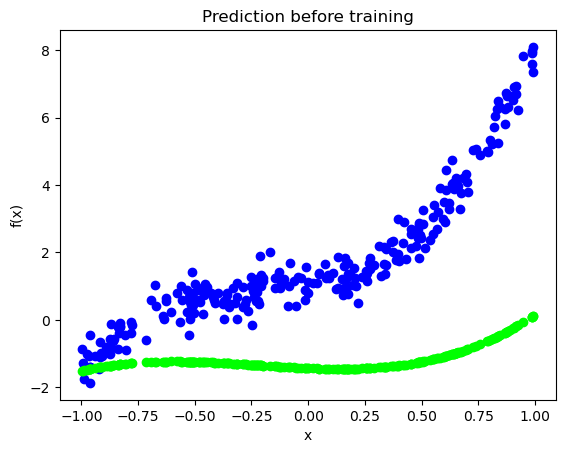

100%|██████████| 300/300 [00:06<00:00, 48.13it/s]


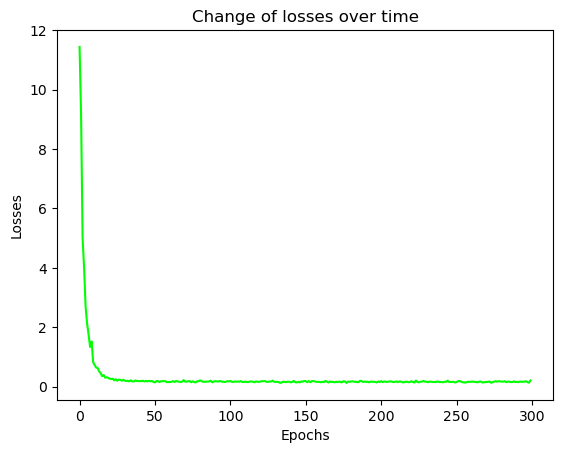

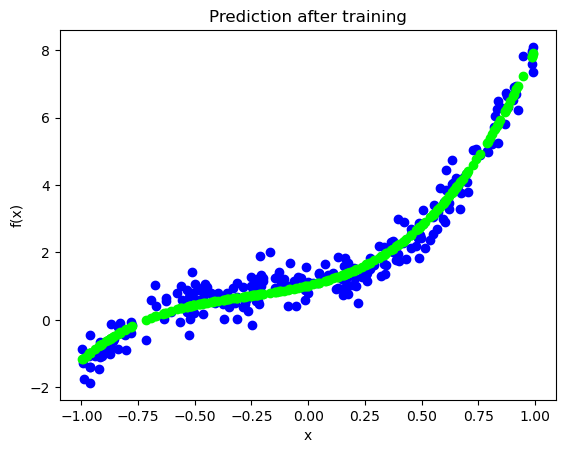

In [100]:
device = select_device()
epochs = 300
degree = 3
step_size = 0.1
batch_size = 256

model = MyPolynomial(degree, device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=step_size)
loss_function = torch.nn.MSELoss()
sampler = unknown_polynomial_random_sampler(degree, xaxis=[-1, 1], device=device)
xs, ys = take_batch_from_sampler(sampler, batch_size)

params = dict(xs=xs, xlabel="x", ylabel="f(x)", plotter=plt.scatter)

plot_1d_tensors(ys_lists=[ys, model(xs)], title="Prediction before training", **params)
visualize_training(model, optimizer, loss_function, sampler, epochs, batch_size, visualize=True)
plot_1d_tensors(ys_lists=[ys, model(xs)], title="Prediction after training", **params)

## Aufgabe 4
4. In der Einstiegspräsentation haben wir gesehen, dass ein Neural Network aus aufeinandergestapelten Schichten linearer Funktionen und nicht-linearer Funktionen besteht. Implementieren Sie ein eigenes PyTorch-Modul, was eine nicht-lineare Funktion repräsentiert (Tipp: Nutzen Sie nicht das Polynom aus Aufgabe 3 sondern wählen Sie eine aus der Einstiegspräsentation). Bauen Sie aus diesem Modul und Ihrem Modul aus Aufgabe 1 einen Stapel "lineare Funktion → nicht-lineare Funktion → lineare Funktion" (bspw. mithilfe von [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Wie schlägt sich dieses MLP im Training mit Ihren mehrdimensionalen Beispieldaten aus 2.?


In [107]:
class Relu(torch.nn.Module):
    def forward(self, x):
        return torch.max(0, x)

In [115]:
class MyModul(torch.nn.Module):
    def __init__(self, n, m):
        super().__init__()
        self.model = torch.nn.Sequential(
            MyLinear_mehrdim(n=n, m=4),
            Relu(),
            MyLinear_mehrdim(n=4, m=m)
        )
        
    def forward(self, x):
        return self.model(x)



### Training

In [116]:
def train_modul(model, lr, epochs, x, y):
    predictions = [] # wir zeichnen unsere Predictions auf

    for i in range(epochs):
        y_prediction = model.forward(x)
        if i % 50 == 0:
            predictions.append(y_prediction.reshape(-1).tolist())
        mse = torch.mean((y - y_prediction)**2)
        mse.backward()
        with torch.no_grad():
            for param in model.parameters():
                param.sub_(param.grad * lr)
        model.zero_grad()
    
    return predictions

In [117]:
modul_transformation = MyModul(n, m)
predictions_m = train_modul(modul_transformation, lr=0.001, epochs=1000, x=x_1, y=y_1)

TypeError: max() received an invalid combination of arguments - got (int, Tensor), but expected one of:
 * (Tensor input)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


In [114]:
%%capture
anim_m = training_animation(list([i for i in range(num_examples)]), data["f(x)+e"], predictions_m, maximal = 50000)

In [ ]:
IPython.display.HTML(anim_m.to_jshtml())